In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.power import TTestIndPower

plt.style.use('ggplot')
%matplotlib inline

**Задача**

**Задача**

На сайте запущен А/В тест с целью увеличить доход.
В приложенном excel файле вы найдете сырые данные по результатам эксперимента:

user_id
variant_name - тип выборки
revenue - доход принесенный пользователем
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру


In [3]:
df = pd.read_excel("AB_Test_Results (2).xlsx")

df


C:\Users\Василий\PycharmProjects\pythonProject5\venv\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
...,...,...,...
9995,1981,control,0.0
9996,502,variant,0.0
9997,9214,variant,0.0
9998,7741,control,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [5]:
df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

Проверим распределение посльзователей по группам

In [6]:
double = df.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': pd.Series.nunique}).query('VARIANT_NAME > 1')
double 


,USER_ID,VARIANT_NAME
1,3,2
6,10,2
11,18,2
15,25,2
23,40,2
...,...,...
6310,9978,2
6311,9979,2
6313,9982,2
6321,9996,2


Посчитаем, сколько типов выборки встречается у каждого пользователя и избавимся от некорретных строк

In [7]:

df = df[~df['USER_ID'].isin(double['USER_ID'])].sort_values('USER_ID').reset_index(drop=True)
df


,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
1,2,control,0.0
2,2,control,0.0
3,4,variant,0.0
4,5,variant,0.0
...,...,...,...
6065,9992,control,0.0
6066,9993,control,0.0
6067,9995,variant,0.0
6068,9995,variant,0.0


Проверим на полные дубли

In [8]:
df.duplicated().sum()

np.int64(1249)

In [9]:
df = df.drop_duplicates().reset_index(drop=True)
df


,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
1,4,variant,0.0
2,5,variant,0.0
3,6,variant,0.0
4,9,variant,0.0
...,...,...,...
4816,9990,variant,0.0
4817,9992,control,0.0
4818,9993,control,0.0
4819,9995,variant,0.0


Из 10000 записей осталось 4821 (48%).

**Первая рекомендация: проверить систему сплитования трафика.**

Еще систему сплитирования можно на А/А тесте по метрикам

In [10]:
df['REVENUE'].describe()

count    4821.000000
mean        0.134802
std         2.999336
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       196.010000
Name: REVENUE, dtype: float64

In [11]:
#Дропнем выброс 

max = df.REVENUE.max()

df = df[df['REVENUE'] < max]

df



,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
1,4,variant,0.0
2,5,variant,0.0
3,6,variant,0.0
4,9,variant,0.0
...,...,...,...
4816,9990,variant,0.0
4817,9992,control,0.0
4818,9993,control,0.0
4819,9995,variant,0.0


In [12]:
df['VARIANT_NAME'].value_counts()


VARIANT_NAME
control    2413
variant    2407
Name: count, dtype: int64

In [13]:
CONTROL = df[df['VARIANT_NAME']=='control']
VARIANT = df[df['VARIANT_NAME']=='variant']

In [14]:
CONTROL.describe()

,USER_ID,REVENUE
count,2413.000000,2413.000000
mean,5013.734770,0.113780
std,2909.131849,1.156753
min,2.000000,0.000000
25%,2495.000000,0.000000
50%,5011.000000,0.000000
75%,7613.000000,0.000000
max,9998.000000,29.320000


In [15]:
VARIANT.describe()

,USER_ID,REVENUE
count,2407.000000,2407.000000
mean,4968.836311,0.074499
std,2894.149437,0.854413
min,4.000000,0.000000
25%,2437.000000,0.000000
50%,4951.000000,0.000000
75%,7383.000000,0.000000
max,9995.000000,23.040000


Видно, что в VARINAT среднее поменьше, но там и выборка поменьше. Да и вообще среднее неустойчиво к выбросам

In [16]:
df['conversion'] = df['REVENUE'].apply(lambda x: int(x>0))
df.pivot_table(index='VARIANT_NAME',
               columns='conversion',
               values='USER_ID',
               aggfunc='count',
               margins=True)

C:\Users\Василий\AppData\Local\Temp\ipykernel_3664\642918864.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['conversion'] = df['REVENUE'].apply(lambda x: int(x>0))


conversion,0,1,All
VARIANT_NAME,,,
control,2360,53,2413
variant,2364,43,2407
All,4724,96,4820


In [17]:
A = df.query('VARIANT_NAME == "control"')
B = df.query('VARIANT_NAME == "variant"')
n1, n2 = A.shape[0], B.shape[0]
m1, m2 = A[A['conversion']==1].shape[0], B[B['conversion']==1].shape[0]

In [18]:
p1, p2 = m1/n1, m2/n2
p1, p2

(0.021964359718193122, 0.017864561695056087)

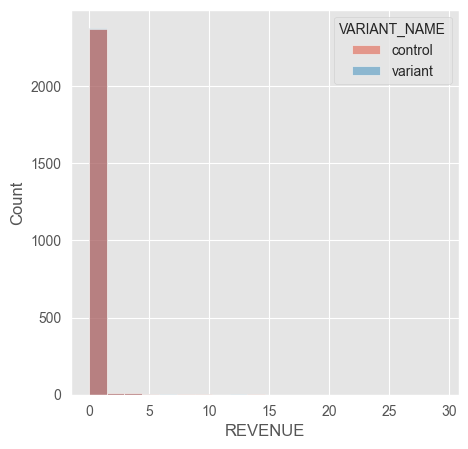

In [19]:
plt.figure(figsize=(5, 5))
sns.histplot(data=df, x='REVENUE', bins=20, hue='VARIANT_NAME');

<Axes: xlabel='REVENUE', ylabel='Count'>

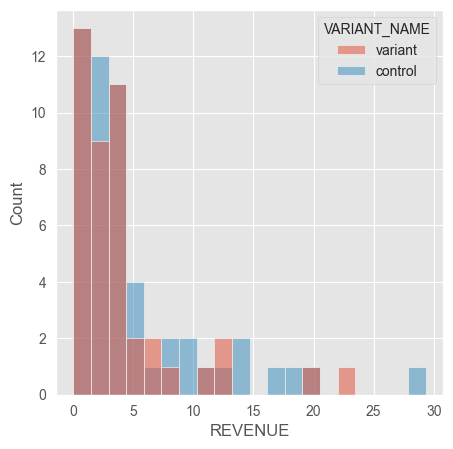

In [20]:
plt.figure(figsize=(5, 5))
sns.histplot(data=df[df['conversion']==1], x='REVENUE', bins=20, hue='VARIANT_NAME')

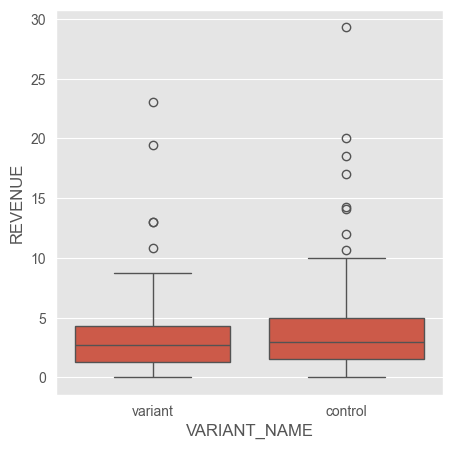

In [21]:
plt.figure(figsize=(5, 5))
sns.boxplot(data=df[df['conversion']==1], y='REVENUE', x='VARIANT_NAME');

Данных очень мало, распределения ненормальные, много выбросов. По графикам видно, что группа B хуже, чем группа А.
Низкая конверсия в покупку, причем в тестовой группе метрика ниже, чем в контрольной.

**Вторая рекомендация: проверить длительность теста, учесть окно конверсии.**

Для проверки нормальности используем критерий Шапиро-Уилка.

In [22]:
alpha = 0.05
pvalue = stats.shapiro(df['REVENUE'])[1]
print('Distribution is ' + ['','not'][pvalue < alpha] + ' normal')

Distribution is not normal


C:\Users\Василий\AppData\Local\Temp\ipykernel_3664\704527691.py:3: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  print('Distribution is ' + ['','not'][pvalue < alpha] + ' normal')


Подтвердили предположение о ненормальности данных.
Т.к. распределение ненормальное, в каждой группе мало данных и существуют выбросы, то используем критерий Манна-Уитни.

In [23]:
stats.mannwhitneyu(x=A['REVENUE'].values, y=B['REVENUE'].values)

MannwhitneyuResult(statistic=np.float64(2916061.0), pvalue=np.float64(0.3040583063744938))

p-value больше уровня значимости 
0.05, следовательно, статистически значимой разницы между группами нет.

Посчитаем, достаточна ли была мощность наших выборок, чтобы анализировать результаты.

In [24]:
M1, M2 = A['REVENUE'].mean(), B['REVENUE'].mean()
D1, D2 = A['REVENUE'].var(), B['REVENUE'].var()

In [25]:
effect_size = (M1-M2)/np.sqrt(((n1-1)*D1 + (n2-1)*D2)/(n1+n2-2))
effect_size

np.float64(0.03862094910812437)

In [27]:
analysis = TTestIndPower()
analysis.solve_power(effect_size=effect_size, alpha=alpha, power=None, nobs1=n1, ratio=n2/n1)

np.float64(0.26825032266638166)

Мощность теста в районе 29%. С такой мощностью мы не можем быть уверены в результатах теста. Мы могли не получить статистически значимую разницу, т.к. у нас недостаточный объем выборки.
Третья рекомендация: рассчитать требуемый размер выборки и избегать преждевременной остановки теста.

В итоге рекомендуется:

1. Не вводить изменения, на которых происходило тестирование группы B.
2. Уточнить дизайн А/В теста и запустить его заново.